In [272]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.decomposition import PCA

from collections import Counter
import warnings 
warnings.filterwarnings("ignore")

## Helper Functions

In [128]:
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))

def limit_vocab(sequences, max_token_id, oov_id):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

def plot_loss_accuracy(history):
    
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    ax.set_ylim(0,1)
    plt.show()


## Read in Data and Split

In [5]:
df = pd.read_pickle("Cleaned Suicide Detection_v2.pkl")
#convert output to numeric
df["class"] = df["class"].apply(lambda x: 1 if x == "suicide" else 0)

In [165]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text_cleaned'], df['class'], test_size=0.2, random_state=42)

# Further split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

print("Train\n", X_train.head(5))


print("\nValidation\n", X_val.head(5))


print("\nTest\n", X_test.head(5))


(139244,) (46415,) (46415,)
Train
 18248     feel teenager sub edits progressive people ged...
101085    gun loaded gun loaded loaded month suppose fan...
49547     know live sober throw account going written sl...
3558                                          officer horny
220372    sometimes want join lost family member loved s...
Name: text_cleaned, dtype: object

Validation
 144097    careful talk decided make post case anyone sim...
121395    give funny line ethan payne find shit funny kn...
135297    need advice hello life bad happy couple friend...
195660    feeling hate towards family failure anyone fee...
223039    god give fucking courage drink drink drink til...
Name: text_cleaned, dtype: object

Test
 74414     month harm free urge get every day day shit si...
149516    start becoming rich start company become affor...
12484     poem haiku game dev hello hello stop fucking s...
14043     honestly got no idea anymore feel everyone fak...
30673     ever cry think unfair life 

## Tokenization, Padding, and Reduction

In [224]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
#Give 2 extra for padding and for unknown words
vocab_size = len(tokenizer.word_index) + 2
print(vocab_size)
#Convert text to numeric index of words
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_val_encoded = tokenizer.texts_to_sequences(X_val)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

58729

In [220]:
print(pd.Series(X_train_encoded).apply(lambda x: len(x)).max())
print(pd.Series(X_train_encoded).apply(lambda x: len(x)).quantile(0.99))

5693
384.0


In [169]:
#99% of text is below 400 words, limit and pad text to 400 tokens 
X_train_padded = pad_data(X_train_encoded, 400)
X_val_padded = pad_data(X_val_encoded, 400)
X_test_padded = pad_data(X_test_encoded, 400)

In [217]:
#vocab size is almost 60k, want to limit space for faster computation 
print("word:", tokenizer.index_word[10000])
print("count:", tokenizer.word_counts[tokenizer.index_word[10000]])

word: brian
count: 25


In [171]:
#10,000 word is brian which doesn't seem to give much information about the classes at that point, 
#take first 9999 token, convert everything else to 10000
X_train_reduced = limit_vocab(X_train_padded, 10000, 10000)
X_val_reduced = limit_vocab(X_val_padded, 10000, 10000)
X_test_reduced = limit_vocab(X_test_padded, 10000, 10000)


## Embedding Model

### Embedding 1 - 1 Layer NN

In [233]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model1 = tf.keras.Sequential()
#Add Embedding layer input dimension is vocab size (9999) + 2 for padding and unknown tokens 
#Output 100 
model1.add(tf.keras.layers.Embedding(input_dim = 10001,
                                   output_dim = 100))
model1.add(tf.keras.layers.GlobalAveragePooling1D())
model1.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

model1.summary()

model1.compile(loss = "binary_crossentropy",
             optimizer = "adam", 
             metrics = ["accuracy"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000100   
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1,000,201
Trainable params: 1,000,201
Non-trainable params: 0
_________________________________________________________________


In [234]:
tf.random.set_seed(1)
np.random.seed(1)
history1 = model1.fit(
    x = X_train_reduced,
    y = y_train,
    validation_split=0.2, 
    epochs=5)

Epoch 1/5
3482/3482 [==============================] - 66s 18ms/step - loss: 0.3784 - accuracy: 0.8431 - val_loss: 0.2840 - val_accuracy: 0.9093
Epoch 2/5
3482/3482 [==============================] - 57s 16ms/step - loss: 0.2431 - accuracy: 0.9123 - val_loss: 0.2486 - val_accuracy: 0.9064
Epoch 3/5
3482/3482 [==============================] - 62s 18ms/step - loss: 0.2194 - accuracy: 0.9225 - val_loss: 0.2463 - val_accuracy: 0.9065
Epoch 4/5
3482/3482 [==============================] - 56s 16ms/step - loss: 0.2084 - accuracy: 0.9268 - val_loss: 0.2364 - val_accuracy: 0.9229
Epoch 5/5
3482/3482 [==============================] - 58s 17ms/step - loss: 0.2001 - accuracy: 0.9297 - val_loss: 0.2518 - val_accuracy: 0.9044


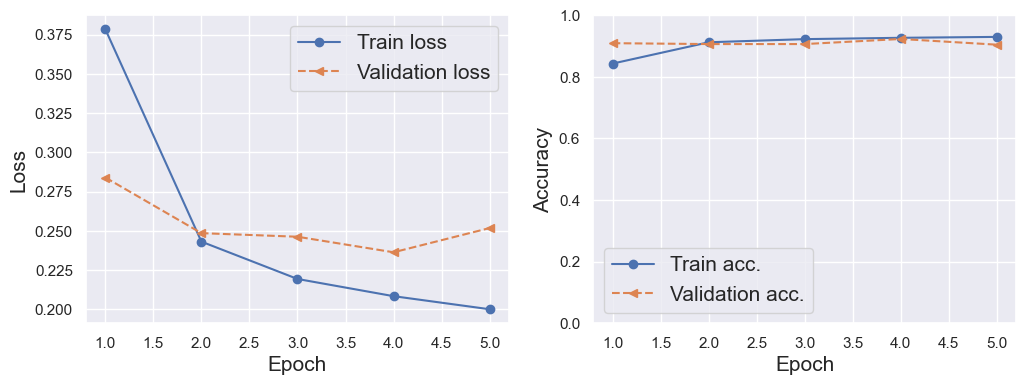

In [235]:
plot_loss_accuracy(history1)

### Embedding 2 - 2 Layer NN 

In [236]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim = 10001,
                                   output_dim = 100))
model2.add(tf.keras.layers.GlobalAveragePooling1D())
model2.add(tf.keras.layers.Dense(16, activation = "relu"))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

model2.summary()

model2.compile(loss = "binary_crossentropy",
             optimizer = "adam", 
             metrics = ["accuracy"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000100   
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,001,733
Trainable params: 1,001,733
Non-trainable params: 0
______________________________________________

In [237]:
tf.random.set_seed(1)
np.random.seed(1)

history2 = model2.fit(
    x = X_train_reduced,
    y = y_train,
    validation_split=0.2, 
    epochs=5)

Epoch 1/5
3482/3482 [==============================] - 62s 17ms/step - loss: 0.2924 - accuracy: 0.8830 - val_loss: 0.2232 - val_accuracy: 0.9194
Epoch 2/5
3482/3482 [==============================] - 59s 17ms/step - loss: 0.2016 - accuracy: 0.9262 - val_loss: 0.2050 - val_accuracy: 0.9230
Epoch 3/5
3482/3482 [==============================] - 67s 19ms/step - loss: 0.1861 - accuracy: 0.9315 - val_loss: 0.2191 - val_accuracy: 0.9195
Epoch 4/5
3482/3482 [==============================] - 60s 17ms/step - loss: 0.1783 - accuracy: 0.9341 - val_loss: 0.2114 - val_accuracy: 0.9237
Epoch 5/5
3482/3482 [==============================] - 75s 21ms/step - loss: 0.1703 - accuracy: 0.9360 - val_loss: 0.2431 - val_accuracy: 0.9152


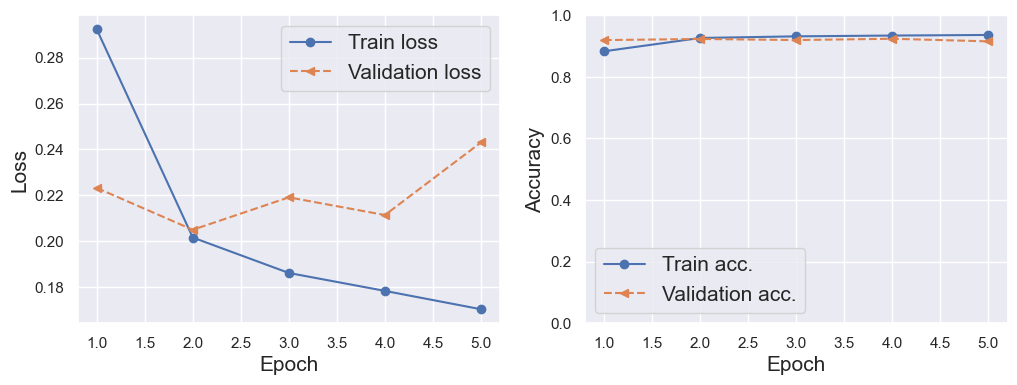

In [238]:
plot_loss_accuracy(history2)

### Embedding 3 - 3 Layer NN

In [239]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(input_dim = 10001,
                                   output_dim = 100))
model3.add(tf.keras.layers.GlobalAveragePooling1D())
model3.add(tf.keras.layers.Dense(32, activation = "relu"))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(16, activation = "relu"))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

model3.summary()

model3.compile(loss = "binary_crossentropy",
             optimizer = "adam", 
             metrics = ["accuracy"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000100   
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                        

In [240]:
tf.random.set_seed(1)
np.random.seed(1)

history3 = model3.fit(
    x = X_train_reduced,
    y = y_train,
    validation_split=0.2, 
    epochs=5)

Epoch 1/5
3482/3482 [==============================] - 69s 19ms/step - loss: 0.2706 - accuracy: 0.8933 - val_loss: 0.2184 - val_accuracy: 0.9169
Epoch 2/5
3482/3482 [==============================] - 59s 17ms/step - loss: 0.1982 - accuracy: 0.9275 - val_loss: 0.2053 - val_accuracy: 0.9229
Epoch 3/5
3482/3482 [==============================] - 62s 18ms/step - loss: 0.1835 - accuracy: 0.9321 - val_loss: 0.2165 - val_accuracy: 0.9213
Epoch 4/5
3482/3482 [==============================] - 65s 19ms/step - loss: 0.1732 - accuracy: 0.9349 - val_loss: 0.2132 - val_accuracy: 0.9255
Epoch 5/5
3482/3482 [==============================] - 64s 19ms/step - loss: 0.1632 - accuracy: 0.9393 - val_loss: 0.2625 - val_accuracy: 0.9190


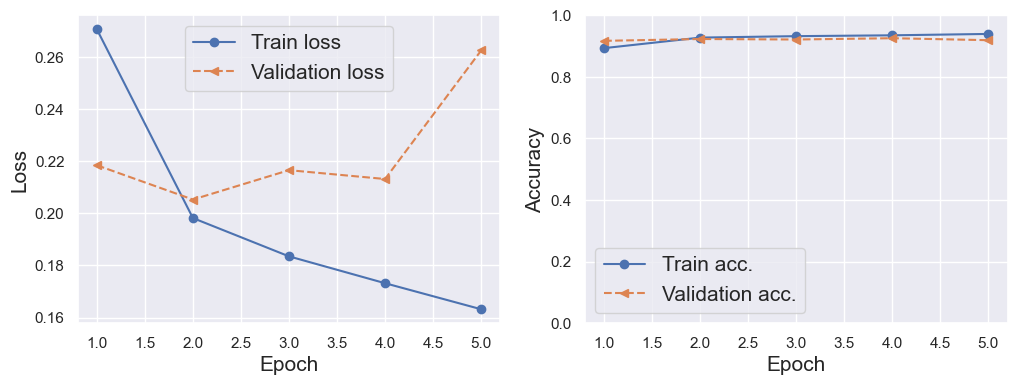

In [241]:
plot_loss_accuracy(history3)

In [248]:
# get trained embeddings
embeddings_trained = model3.layers[0].get_weights()[0]

# remove embedings at index 0 and last index
# these correspond to the additional indices added for padding (0) and out of vocabulary words (size_train_vocab + 1).
embeddings_trained = embeddings_trained[1:-1]

In [349]:
embeddings_trained

array([[-0.03240958,  0.16286139,  0.11938793, ...,  0.14336203,
         0.10660075,  0.12991647],
       [-0.0605204 ,  0.01951114,  0.02718708, ..., -0.03682415,
         0.04738917,  0.07613517],
       [-0.18454681,  0.3024614 ,  0.16581042, ...,  0.1775821 ,
         0.09380636,  0.22513969],
       ...,
       [ 0.28315637, -0.16901079, -0.18276954, ..., -0.21576537,
         0.03959785, -0.21637842],
       [ 0.06249796,  0.41473585,  0.42679772, ...,  0.39128095,
         0.2759978 ,  0.34138486],
       [ 0.31296733,  0.1651876 ,  0.21039397, ...,  0.19130565,
         0.20175922,  0.18370083]], dtype=float32)

In [249]:
embeddings_1d = np.mean(embeddings_trained, axis = 1)

In [247]:
model3.evaluate(X_test_reduced, y_test)

1451/1451 [==============================] - 5s 3ms/step - loss: 0.2436 - accuracy: 0.9216


[0.2435820996761322, 0.9215986132621765]

## Visualize embeddings

In [273]:
# create an instance of the PCA class
pca = PCA(n_components=2) # PCA imported from sklearn.decomposition

# fit the data using the original X_train_std data; tranform X_train_std data
embeddings_trained_pca = pca.fit_transform(embeddings_trained)


In [287]:
def plot_2d_embeddings(embeddings, id_start=1, count=1000):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]
  
  # Get the corresponding words from the reverse index (for labeling).
  tokens = [tokenizer.index_word[i] for i in range(id_start, id_start+count)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.    
plot_2d_embeddings(embeddings_trained_pca, id_start=1, count=2000)

In [ ]:
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_data(X_train_encoded, 400)
X_train_reduced = limit_vocab(X_train_padded, 10000, 10000)


In [330]:
model.predict(limit_vocab(pad_data(tokenizer.texts_to_sequences(np.array(["my wife drive me insane"])),400), 10000, 10000))[0][0]



1/1 [==============================] - 0s 41ms/step


0.22541492